# Solving the Lindblad dynamics of a qubit chain

In this tutorial we walk through an example of solving the time evolution of the density matrix of coupled qubits using `qiskit_dynamics`. The model that we solve consists of a time-independent Hamiltonian for qubits interacting with their nearest neighbors along a ring. In addition, energy relaxation terms acting on each qubit are modeled by using a non-Markovian master equation in Lindblad form. We will discuss the system's steady state as a function of the model parameters.

In the sections below we define a model, solve the dynamics and plot some observables using the following steps:
1. Define the number of qubits and precompute some matrix operators.
2. Define all relevant parameters and setup a `Solver` instance with the model of the system, consisting of the Hamiltonian and the jump operators of the Lindblad dissipator.
3. Define the initial state and simulation and output times for the initial value problem, and evolve the system state.
4. Define observables and calculate their values as a function of time.
5. Plot some observables and discuss the results.

The model that we solve describes the time evolution of $N$ qubits with coherent dynamics dictated by a given Hamiltonian, and the environment modeled as a memory-less (Markovian) bath. Together, the density matrix evolves according to the Lindblad master equation,

$$\partial_t\rho = -\frac{i}{\hbar} \left[H,\rho\right] + \mathcal{D}[\rho].$$

The Hamiltonian is composed of a sum of single-qubit terms and two-qubit interactions,

$$H = H_0 + H_I.$$

We tak the qubits to have identical parameters, with a diagonal term of frequency $\nu$ and a transverse term of amplitude $\Omega$. The single-qubit part of the Hamiltonian is

$$H_0 = \frac{1}{2}\sum_i^N \left[2 \pi \nu {\sigma^z}_i + 2 \pi \Omega {\sigma^x}_i\right],$$

where $\sigma^a_i$ with $a\in\{x,y,z\}$ are the Pauli matrices (also written as $\{X,Y,Z\}$).

We set the interactions between nearest-neighbor qubits to be of "flip-flop" type, also called "XY" coupling. We consider periodic boundary conditions, such that the last qubit is connected to the first qubit as well, with

$$H_I =  \frac{1}{2} \sum_{\langle i,j\rangle}2 \pi J \left[{\sigma^x_i \sigma^x_j} + {\sigma^y_i \sigma^y_j}\right]$$

In `qiskit`, each qubit's ground state is by convention the state $|0\rangle$ which is the eigenstate of $\sigma^z$ with eigenvalue 1 (the state that is known also as "up"). Therefore the action of energy relaxation terms describing damping into the environment tend to bring qubits to this state, as generated by the Lindblad dissipator

$$\mathcal{D}[\rho] = \sum_i \Gamma\left(\sigma_i^+ \rho\sigma_i^- - \frac{1}{2} \{\sigma_i^- \sigma_i^+,\rho\}\right).$$

## 1. Prepare the single-qubit operators

In `qiskit-dynamics`, dynamical simulations are defined using the operators that act the states appearing in the differential equations. We start by creating the single-qubit operators that act on each qubit in the simulation, and are represented as matrices in the Hilbert space of $N$ qubits. Using `qiskit` library routines, it is easy to create $N$-qubit operators that are products of basic single-qubit operators, by using labels (descriptive strings) with each character in the label defining one qubit.

Below, we first set the number of qubits $N$ to be simulated, and then prepare and store the single-qubit Pauli operators that will be used in the rest of this tutorial.

In [14]:
from qiskit.quantum_info import Operator

N = 6

x_ops = []
y_ops = []
z_ops = []
qubits = range(N)
identities = ['I'] * N

for i in qubits:
	op = identities.copy()
	op[i] = 'X'
	s_x = Operator.from_label(''.join(op))
	x_ops.append(s_x)
    
	op[i] = 'Y'
	s_y = Operator.from_label(''.join(op))
	y_ops.append(s_y)
    
	op[i] = 'Z'
	s_z = Operator.from_label(''.join(op))
	z_ops.append(s_z)

## 2. Setup the solver

In this section we setup a `Solver` class that stores and manipulates the model to be solved. 
In the following, we will set $\hbar=1$ and set the damping rate to be $\Gamma \equiv 1$. This sets the time units to the characteristic energy relaxation time (commonly referred to as $T_1=1/\Gamma$), with the other frequency parameters scaled accordingly. Below, we first set a few values for these free parameters, and then create the Hamiltonian matrix and the list of dissipator operators. We build the full Hamiltonian matrix by summing all single-qubit and two-qubit terms. Since there are no time-dependent terms, and we do not plan to take partial derivatives of parameters, the accompanying `Signal` class instance is set to the constant value `1`. See the other tutorials for various generalizations of this approach supported with `qiskit-dynamics`.

In [15]:
import numpy as np
from qiskit_dynamics import Solver
from qiskit_dynamics.signals import Signal

nu = 4.
Omega = 1.
J = 4.
Gamma = 1.

_2_pi = 2 * np.pi
H = Operator.from_label(''.join(identities))
for i in qubits:
	s_x = x_ops[i]
	s_z = z_ops[i]
	H += .5 * _2_pi * Omega * s_x
	H += .5 * _2_pi * nu * s_z
    
	if N > 1:
		j = i + 1 if i < (N - 1) else 0  # Nearest neighbors, with periodic boundary conditions
		op = identities.copy()
		op[i] = 'X'
		op[j] = 'X'
		H += .5 * _2_pi * J * Operator.from_label(''.join(op))
        
		op[i] = 'Y'
		op[j] = 'Y'
		H += .5 * _2_pi * J * Operator.from_label(''.join(op))

L_ops = []
L_sig = []
for i in qubits:
	s_x = x_ops[i]
	s_y = y_ops[i]
	L_ops.append(s_x + 1j * s_y)
	L_sig.append(Signal(Gamma))

solver = Solver(hamiltonian_operators = [H], hamiltonian_signals = [Signal(1.)],
				dissipator_operators = L_ops, dissipator_signals = L_sig)

## 3. Define the simulation parameters and solve the dynamics

We now define the initial state for the simulation, the time span to simulate for, and the intermediate times for which the solution is requested.

In [17]:
from qiskit_dynamics.dispatch import Array
from qiskit.quantum_info import DensityMatrix

t_final = 2. / Gamma
tau = .01

y0 = DensityMatrix.from_label('0' * N)

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

print("\nStarting numerical simulation -> ")
sol = solver.solve(t_span = Array((0., t_final)), y0 = y0, t_eval = Array(t_eval))
print("Done!")


Starting numerical simulation -> 
Done!


## 4. Define the observables and calculate their values

Below we calculate single-qubit Pauli expectation values for each qubit as a function of time (which define also the Bloch vector),

$$\langle\sigma_i^a(t)\rangle,$$

and also the mean components of the collective Bloch vector over all qubits, at each evaluation time,

$$\frac{1}{N}\sum_i\langle\sigma_i^a(t)\rangle.$$

Since both the model and the initial state as defined above are translation invariant (all qubits have identical parameters, and there is no boundary), we expect the solution to remain translation invariant as well. Hence the mean Bloch vector should be equal to any qubit's Bloch vector, and observing that this equality holds is a simple and useful verification of the numerical solution that will be added in the next section.

In [18]:
n_times = len(sol.y)
x_data = np.zeros((N, n_times))
y_data = np.zeros((N, n_times))
z_data = np.zeros((N, n_times))
x_mean = np.zeros((n_times,))
y_mean = np.zeros((n_times,))
z_mean = np.zeros((n_times,))

for t_i, sol_t in enumerate(sol.y):
	for qubit, obs in enumerate(x_ops):
		x_data[qubit, t_i] = sol_t.expectation_value(obs).real
	x_mean[t_i] = np.mean(x_data[:, t_i])
    
	for qubit, obs in enumerate(y_ops):
		y_data[qubit, t_i] = sol_t.expectation_value(obs).real
	y_mean[t_i] = np.mean(y_data[:, t_i])
    
	for qubit, obs in enumerate(z_ops):
		z_data[qubit, t_i] = sol_t.expectation_value(obs).real
	z_mean[t_i] = np.mean(z_data[:, t_i])

## 5. Plot some observables and discuss the results

Finally, let's plot some of the results of our dynamical simulation, using the single-qubit observables calculated as a function of time. We plot both the time evolution of the collective Bloch vector, and the Bloch vector at the final time, depicted in 3D within the Bloch sphere. We also print a warning if the Bloch vector at the final time is not translation invariant according to a simplified random check of two values (taken up to a small numerical precision).

Looking at the figures below, we see that for the above parameters the steady state is nearly pure, with a large ground state component and a small tilt along the negative $x$ axis. The direction and magnitude of the collective Bloch vector is determined by a nontrivial competition between the single-site terms, the qubit interactions, and the damping. To test this statement, if you go back and vary a bit the interaction strength $J$, you can see that the steady state may change significantly. For example for $J=5$ the collective Bloch vector will slightly tilt along $+x$, while for $J=3$ it will significantly shorten (the steady state becomes a mixed state), becoming tilted along $-y$. This non-monotonous dependence of the Bloch vector can be systematically analyzed - we encourage you to try it!

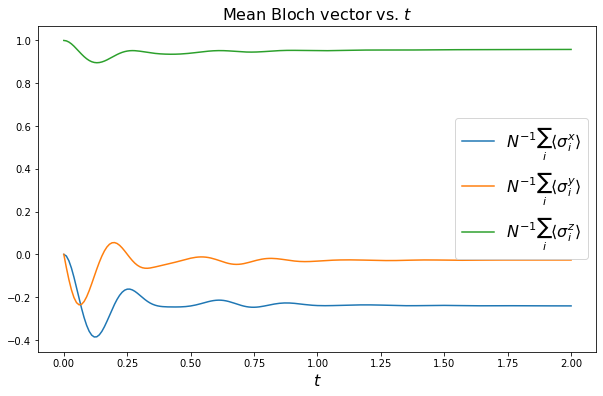

In [19]:
from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt
%matplotlib inline

fontsize = 16

_, ax = plt.subplots(figsize = (10, 6))
plt.rcParams.update({'font.size': fontsize})
plt.plot(t_eval, x_mean, label = '$ N^{-1}\sum_i \\langle \\sigma^x_i \\rangle$')
plt.plot(t_eval, y_mean, label = '$ N^{-1}\sum_i \\langle \\sigma^y_i \\rangle$')
plt.plot(t_eval, z_mean, label = '$ N^{-1}\sum_i \\langle \\sigma^z_i \\rangle$')
plt.legend(fontsize = fontsize)
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_title('Mean Bloch vector vs. $t$', fontsize = fontsize)

plot_bloch_vector([x_mean[-1], y_mean[-1], z_mean[-1]],
                  f'Mean Bloch vector at $t = {t_eval[-1]}$')

if N > 1 and ((abs(x_mean[-1]) > 1e-5 and abs(x_data[0, -1] / x_mean[-1] - 1) > 1e-5 or
              (abs(z_mean[-1]) > 1e-5 and abs(z_data[1, -1] / z_mean[-1] - 1) > 1e-5))):
    print("The solution at the final time appears to break translation invariance. "
          "The precision of the simulation should be examined.")